In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plotter import *

G = 6.67430e-11  # gravitational constant
AU = 1.496e+11 # astronomical unit, m
SM = 1.989e30 # solar mass, kg

In [2]:
class Body:
    def __init__(self, name, mass, position, velocity):
        self.name = name
        self.mass = mass
        self.position = np.array(position)
        self.velocity = np.array(velocity)

In [3]:
# Force calculator class with three children, brute force, barnes-hut, and fast multipole
class ForceCalculator:
    def compute_accelerations(self, pos, masses):
        pass
    
# Naively compute all O(n^2) force pairs
class DirectForceCalculator(ForceCalculator):
    def compute_accelerations(pos, masses):
        N = len(pos)
        accelerations = np.zeros((N, 3))

        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                r = pos[j] - pos[i]
                a = (G * masses[j] / np.linalg.norm(r)**3) * r
                accelerations[i] += a
        return accelerations

class BarnesHutForceCalculator(ForceCalculator):
    def compute_accelerations(pos, masses):
        return 0

class FastMultipoleForceCalculator(ForceCalculator):
    def compute_accelerations(pos, masses):
        return 0

In [4]:
# Integrator class with two children, RK4 and Leapfrog (symplectic)
class Integrator():

    def _derivatives(self, pos, vel):
        acc = self.force_calculator.compute_accelerations(pos, self.masses)
        return vel, acc

    def __init__(self, bodies, force_calculator):
        self.bodies = bodies
        self.masses = np.array([b.mass for b in bodies])
        self.force_calculator = force_calculator
        
    def get_state(self):
        pos = np.array([b.position for b in self.bodies])
        vel = np.array([b.velocity for b in self.bodies])
        return pos, vel

    def set_state(self, pos, vel):
        for i, body in enumerate(self.bodies):
            body.position = pos[i]
            body.velocity = vel[i]
    
class RK4Integrator(Integrator):

    def step(self, dt):
        p0, v0 = self.get_state()

        k1v, k1a = self._derivatives(p0, v0)
        k2v, k2a = self._derivatives(p0 + 0.5 * dt * k1v, v0 + 0.5 * dt * k1a)
        k3v, k3a = self._derivatives(p0 + 0.5 * dt * k2v, v0 + 0.5 * dt * k2a)
        k4v, k4a = self._derivatives(p0 + dt * k3v, v0 + dt * k3a)

        new_pos = p0 + (dt/6)*(k1v + 2*k2v + 2*k3v + k4v)
        new_vel = v0 + (dt/6)*(k1a + 2*k2a + 2*k3a + k4a)
        self.set_state(new_pos, new_vel)

class LeapfrogIntegrator(Integrator):

    def __init__(self, bodies, force_calculator):
        self.bodies = bodies
        self.masses = np.array([b.mass for b in bodies])
        self.force_calculator = force_calculator
        # Special for leapfrog!
        self.prev_acc = np.zeros((len(bodies), 3))
    
    def step(self, dt):
        p0, v0 = self.get_state()
        
        a0 = self.prev_acc
        a1 = self._derivatives(p0, v0)[1]

        p1 = p0 + (v0 * dt) + 0.5 * (a0 * dt**2)
        v1 = v0 + 0.5 * (a0 + a1) * dt

        self.set_state(p1, v1)
        self.prev_acc = a1

In [5]:
# simulation
class NBodySimulation:
    def __init__(self, bodies, Integrator, ForceCalculator):
        self.integrator = Integrator(bodies, ForceCalculator)
    
    def plot():
        # plot something from self.bodies
        return 0

    def run(self, dt, steps):
        # position history
        num_bodies = len(self.integrator.bodies)
        pos_hist = np.zeros((steps, num_bodies, 3))
        
        for i in range(steps):
            self.integrator.step(dt)
            for j, body in enumerate(self.integrator.bodies):
                pos_hist[i][j] = body.position
                
        return pos_hist

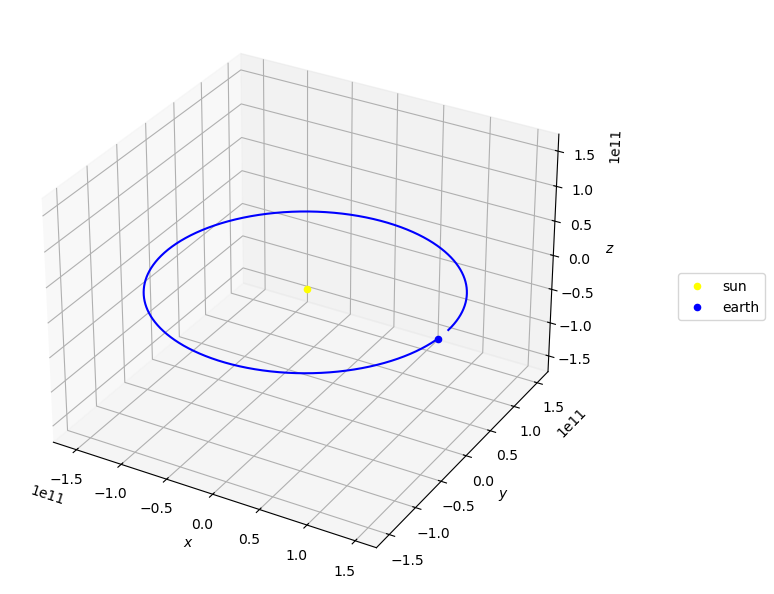

In [7]:
p1 = Body("Sun", SM, [0, 0, 0], [0, 0, 0])
p2 = Body("Earth", 5.972e24, [AU, 0, 0], [0, 30000, 0])
p3 = Body("Searth", 5.972e27, [15e8, 0, 14e6], [100, 200, 300])
pluto = Body("Pearth", 1.31e22, [39.5*AU, 0, 0], [0, 4740, 0])

sim = NBodySimulation([p1, p2], LeapfrogIntegrator, DirectForceCalculator)
day = 60

soln = sim.run(day, 366*60*24)

plot_3d_trajectory(soln, 10, 10, ['sun', 'earth'], ['yellow', 'blue'], True)